# Multiparametrisk MRI (d) - Styrt (KNN) vevsklassifikasjon

versjon 13.01.2020 A. Lundervold og A.S. Lundervold

I denne sesjonen vil du lære å klassifisere vev i multispektrale MR bilder ved bruk av **styrt** (supervised) **klassifikasjon**. For styrt klassifikasjon vil vi benytte treningen (i.e. treningsmasken) med seks ulike klasser (vevstyper) fra forrige sesjon og et motsvarende fire-kanaler multispektralt MR opptak. 

# Teori:  K-nærmest nabo klassifikasjon (KNN)

Kort beskrivelse og forklaring av [KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)-klassifikasjon:

In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression:

 - In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.
 - In k-NN regression, the output is the property value for the object. This value is the average of the values of k nearest neighbors.

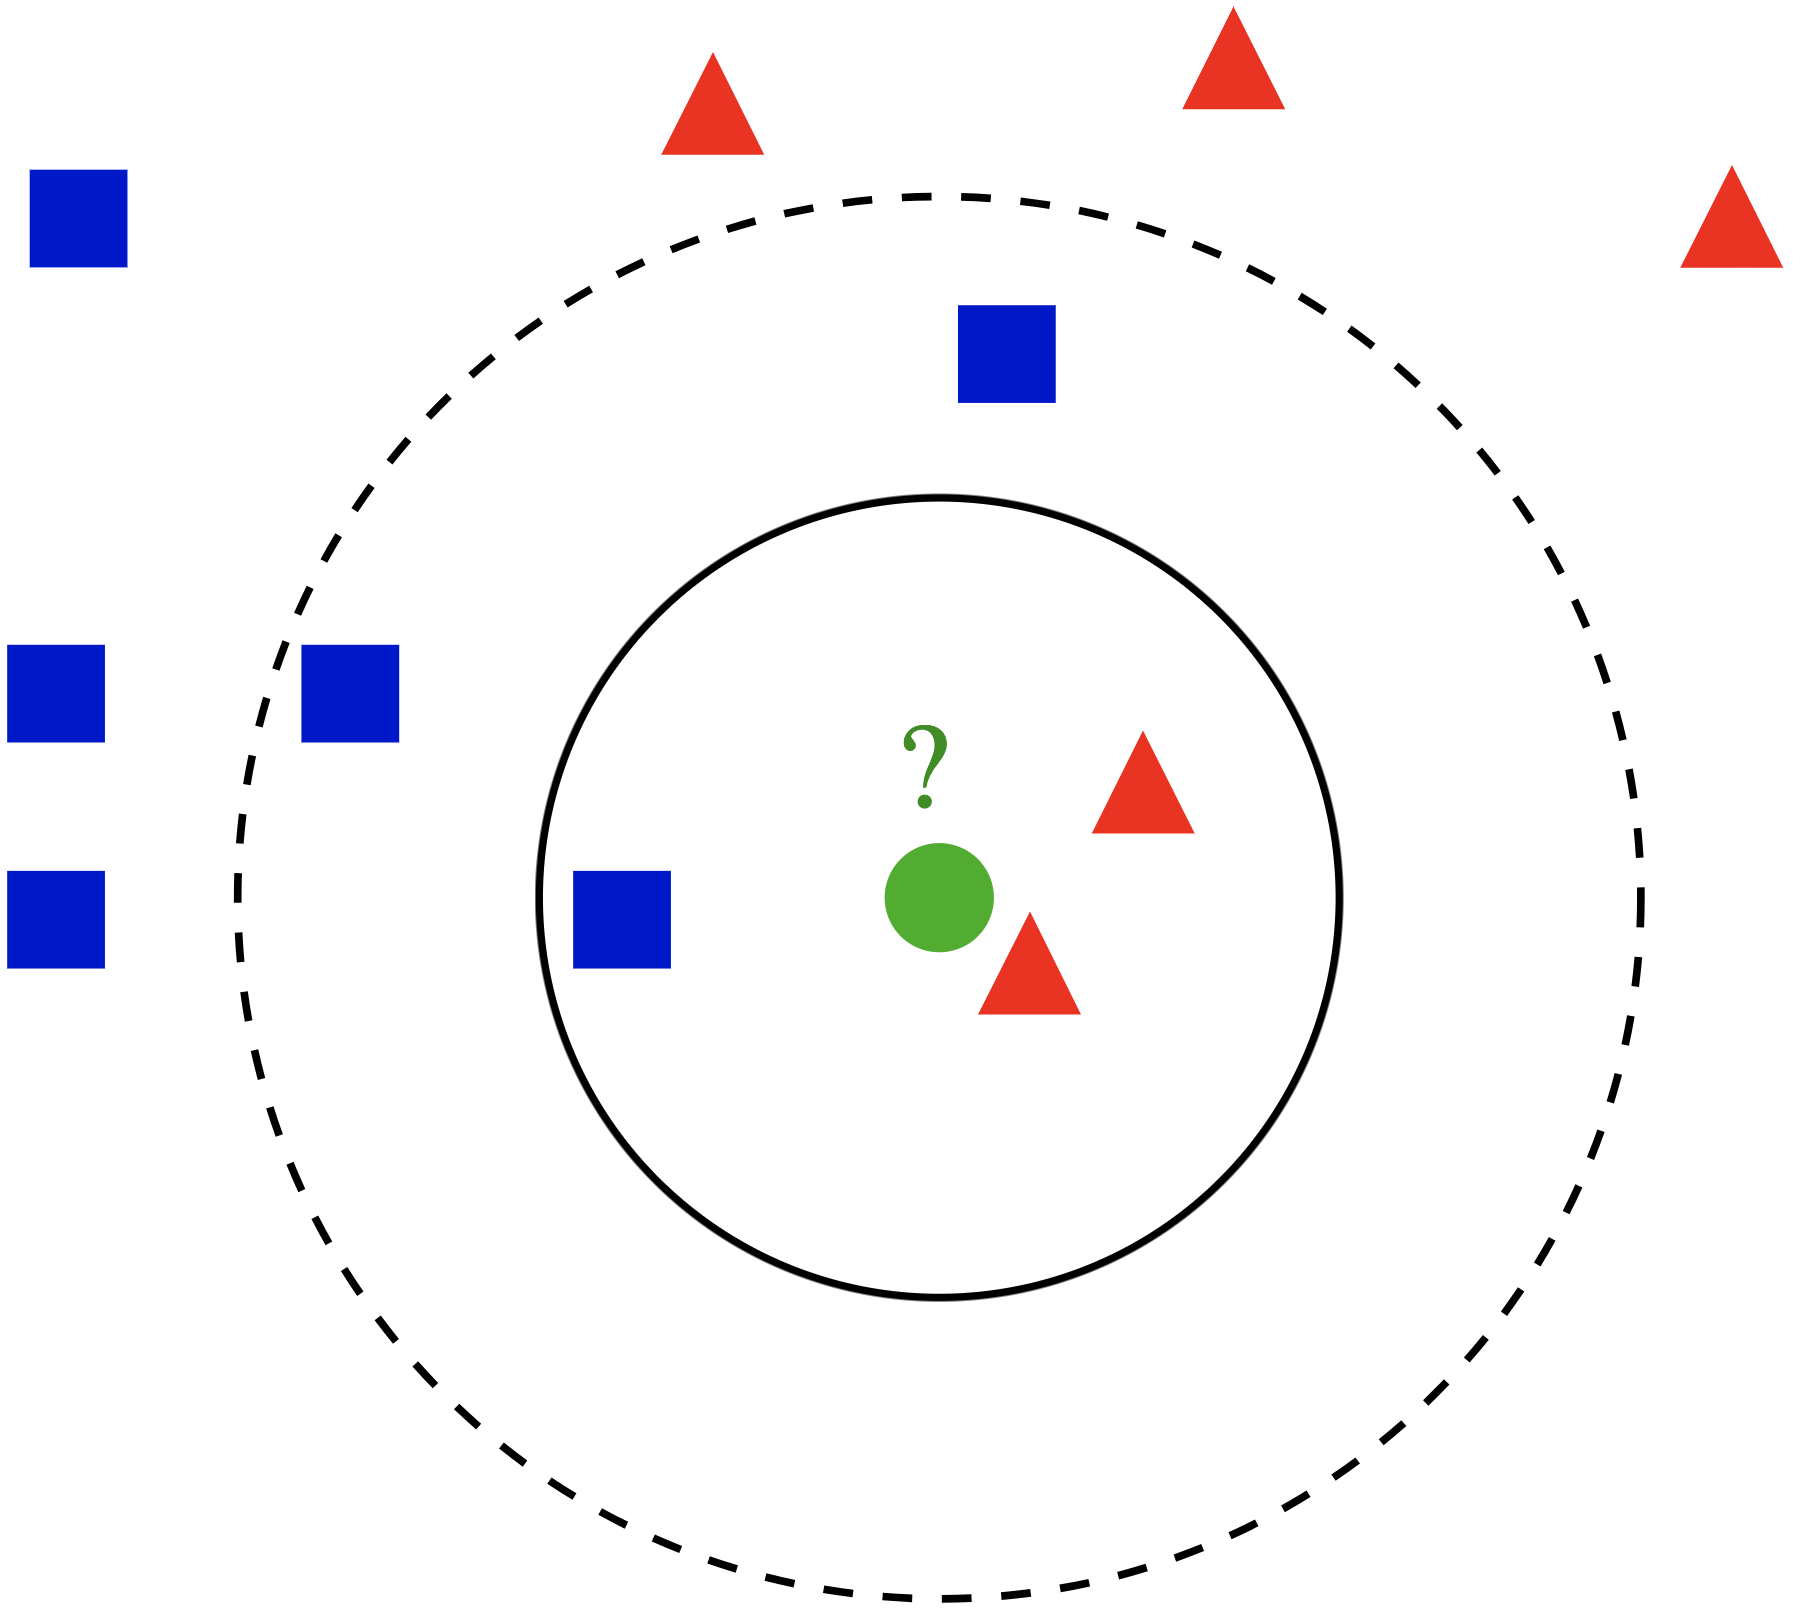

In [1]:
from IPython.display import Image
Image(filename='./assets/knn_illustration.png', width=600)

_Eksempel på en k-NN klassifikasjon._ 

- Test-observasjonen (fylt grønn sirkel) med ukjent klasse-tilhørighet skal klassifiseres enten til klassen merket med blå kvadrater eller den andre klassen merket med røde triangler. 

- Hvis k = 3 (sirkel med heltrukken strek) vil den ukjente observasjonen tilordnes den andre klassen siden det er 2 triangler og bare 1 kvadrat innenfor den innerset sirkel med de 3 nærmeste naboer.

- Hvis k = 5 (sirkel med stiplet strek) vil den ukjente observasjonen bli tilordnet den første klassen (3 kvadrater vs. 2 triangler blant de 5 nærmeste naboer), i.e. majoritets-votering. 

- For detaljert forklaring, se [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) på Wikipedia

# Fire-kanal multispektralt bilde og tilhørende treningsmasker

Vi skal arbeidemed et fire-kanals multispektralt bilde (skive 60 fra et multispektral 3D opptak),  <br>
rapportert i  Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326, <br>
og en manuelt tegnet trenings-maske med 6 vevstyper (farge-kodet i [R,G,B]) som følger: 

 - AIR (luft/ben) i Magenta [255,0,255]
 - GM  (grå substans) i Rød  [255,0,0] 
 - WM  (hvit substans) i Cyan [0,255,255]
 - CSF (cerebrospinalvæske) i Blå [0,0,255]
 - MUS (muskel) i Grønn [0,255,0] 
 - FAT (fett) i Gul [255,255,0]
 
**SJEKK UT:** *Multispektral MRI analyse startet med arbeidet til [Vannier et al.](https://www.ncbi.nlm.nih.gov/pubmed/3964938), Radiology 1985 - inspirert av forskning ved NASA!*

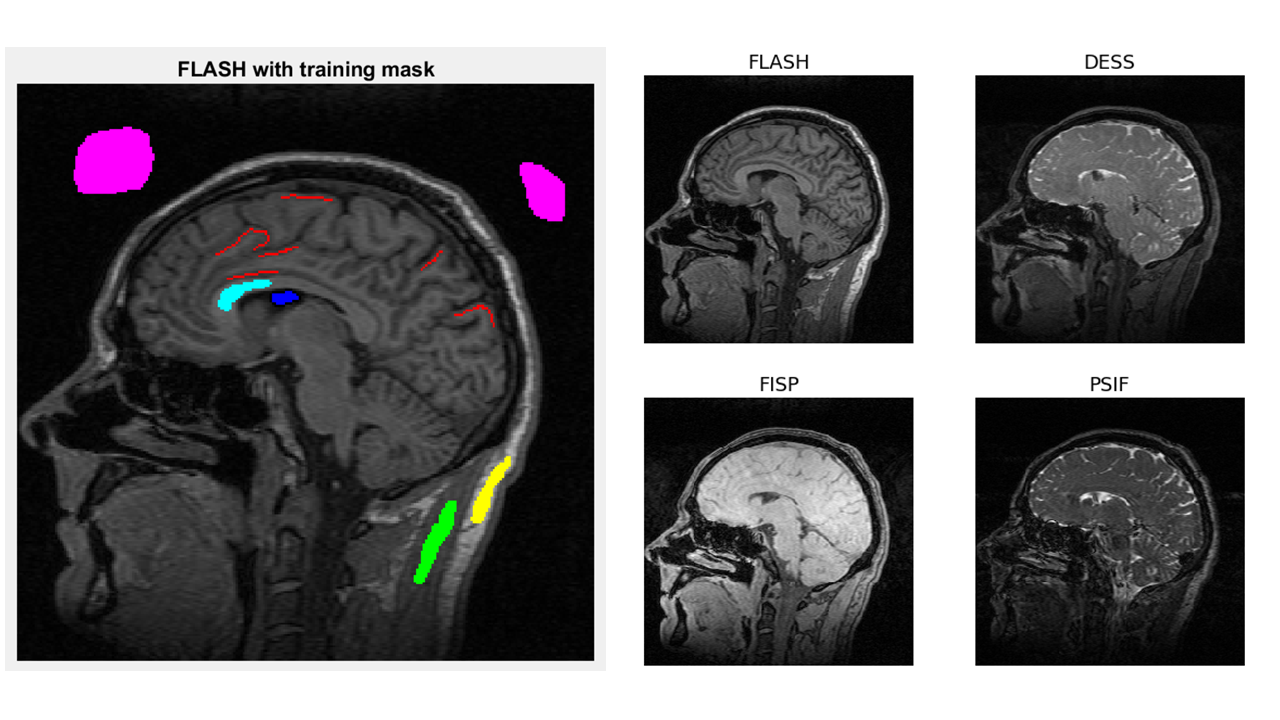

In [2]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=600)

# Sett opp våre Python-omgivelser

In [3]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image.image import mean_img
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython

home = os.path.expanduser('~')  # To make path to local home directory

print('nibabel:', nib.__version__)
import sklearn
print('scikit-learn:', sklearn.__version__)

nibabel: 3.0.0
scikit-learn: 0.22.1


# MRI pulssekvenser (features) og vevstyper (klasser)

**Definer kataloger, kanal-navn (MRI pulssekvenser) og klasse-navn (vevstyper) som inngår**

In [4]:
mytestdata = '../testdata'
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']
class_names = ['air', 'gm', 'wm', 'csf', 'mus', 'fat']

# Les inn multispektralt MR bilde, treningsmasker og ROI maske

In [5]:
# Using nibabel to read the multispectral image (and the training mask)
fn_multispectral = '../data/mri/multispectral_mri.nii.gz'
img = nib.load(fn_multispectral)
fn_tmsk = '../data/mri/training_mask_1_6.nii.gz'
tmsk = nib.load(fn_tmsk)
fn_roimsk = '../data/mri/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)

## Vis karakteristika ved det multispektrale NIFTI-bildet

In [6]:
print('**Multispectral image info:**')
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
dat = img.get_fdata()
print('min = %.1f' % dat.min())
print('max = %.1f' % dat.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
data = np.uint16(dat.squeeze())
print('shape of 2D+spectral img_data = ',data.shape)
print('dtype of 2D+spectral img_data = ',data.dtype)
print('img affine:', img.affine)

**Multispectral image info:**
shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral img_data =  (256, 256, 4)
dtype of 2D+spectral img_data =  uint16
img affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


og tilhørende treningsmaske

In [7]:
print('**Training mask info:**')
print('shape = ', tmsk.header.get_data_shape())
print('voxel size = ', tmsk.header.get_zooms())
print('dtype tmsk = %s' % tmsk.header.get_data_dtype())
tmsk_data = tmsk.get_fdata().squeeze()
print('min mask value = %.0f' % tmsk_data .min())
print('max mask value = %.0f' % tmsk_data .max())
print('shape of 2D tmsk_data = ', tmsk_data.shape)
print('tmsk affine:', tmsk.affine)

**Training mask info:**
shape =  (256, 256, 1, 1)
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype tmsk = int16
min mask value = 0
max mask value = 6
shape of 2D tmsk_data =  (256, 256)
tmsk affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


samt ROI masken

In [8]:
print('**Brain ROI mask info:**')
print('shape = ', roimsk.header.get_data_shape())
print('voxel size = ', roimsk.header.get_zooms())
print('dtype roimsk = %s' % roimsk.header.get_data_dtype())
roimsk_data = roimsk.get_fdata().squeeze()
print('min mask value = %.0f' % roimsk_data .min())
print('max mask value = %.0f' % roimsk_data .max())
print('shape of 2D roimsk_data = ', roimsk_data.shape)
print('roimsk affine:', roimsk.affine)

**Brain ROI mask info:**
shape =  (256, 256, 1, 1)
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype roimsk = int16
min mask value = 0
max mask value = 1
shape of 2D roimsk_data =  (256, 256)
roimsk affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


# Vis det multispektrale MRI bildet (de enkelte kanaler)

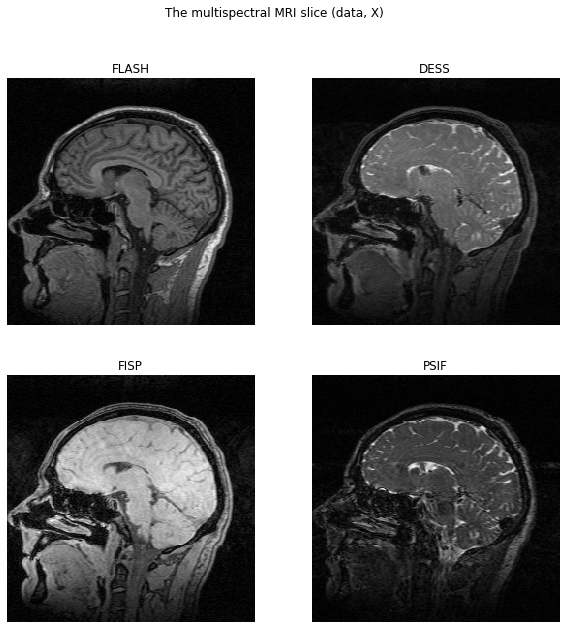

In [9]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(data[:, :, k].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle("The multispectral MRI slice (data, X)") 
plt.tight_layout
plt.show()

# Vis treningsmasken med farge-koding av klassene

(i henhold til en egen-definert fargetabell)

Vi bruker en **dictionary** for fargekode-tabellen:

In [10]:
import matplotlib
col_code = {
    'BCK': [255,255,255], # White (background)
    'AIR': [255,0,255],   # Magenta 
    'GM':  [255,0,0],     # Red 
    'WM':  [0,255,255],   # Cyan 
    'CSF': [0,0,255],     # Blue 
    'MUS': [0,255,0],     # Green 
    'FAT': [255,255,0]    # Yellow 
}
cla_names = list(col_code.keys())
ncla = len(cla_names)
colors = np.array(list(col_code.values()))/255   # scale to interval 0-1
mycmap = matplotlib.colors.ListedColormap(colors)
cla_cmap = matplotlib.cm.get_cmap(mycmap, ncla)   # ncla discrete colors

Lag en liste av klassenavn og tilhørende klasse-numre

In [11]:
cla_names_num = []
for i in range(ncla):
    str = cla_names[i] + ' [%d]' % (i)
    cla_names_num.append(str)
cla_names_num

['BCK [0]', 'AIR [1]', 'GM [2]', 'WM [3]', 'CSF [4]', 'MUS [5]', 'FAT [6]']

Figur med de farge-kodete treningsmaskene:

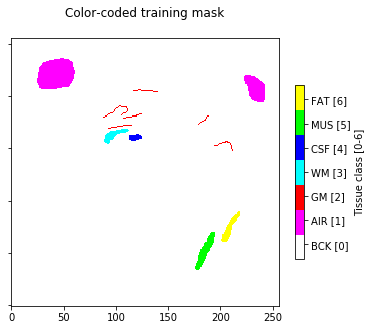

In [12]:
fig, ax = plt.subplots(figsize=(6,8))

cmsk = ax.imshow(tmsk_data[:, :].T)
clim=cmsk.properties()['clim']
cax = ax.imshow(tmsk_data[:, :].T, cmap=cla_cmap, origin='lower', clim=clim)
ax.set_title('Color-coded training mask\n')
ax.axis('on')
ax.set_yticklabels("")
#ax.set_xticklabels("")
cbar = fig.colorbar(cax, shrink=0.4, label='Tissue class [0-%d]' % clim[1]) 
tick_locs = np.linspace(clim[0]+0.5, clim[1]-0.5, ncla)
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(cla_names_num)
plt.tight_layout
plt.show()

#fig.savefig('%s/prj/ELMED219/results/training_mask_1_6_color_coded.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

# Lager et data frame FVB direkte fra MRI data og treningsmaske

Bruker `np.where()`for å finne lokasjoner til de enkelte vevklassene som det er trent på, for deretter å hente ut egenskapsvektorene fra de multispektrale bildedata:

In [13]:
# Find pixel locations corresponding to AIR (class 1), GM (class 2), ..., FAT (class 6)
frames = pd.DataFrame()   # Create an empty data frame
for cn, cla in enumerate(class_names):
    ind = np.where(tmsk_data == cn+1)  # Find indices (x,y) for given class, class numbers start at 1 (not 0)
    df = pd.DataFrame(np.asarray(data[ind[0][:],ind[1][:],:]), columns = chn_names)
    df.insert(len(df.columns), 'Class', class_names[cn].upper())  # Last entry is class name
    frames = frames.append(df)
    
# Concatinate the frames
FVB = pd.concat([frames], ignore_index=True)

Sjekk noen treningsdata

In [14]:
FVB.head()

,FLASH,DESS,FISP,PSIF,Class
0,7,6,10,2,AIR
1,0,6,8,0,AIR
2,8,2,4,11,AIR
3,3,7,2,11,AIR
4,5,3,0,6,AIR


In [15]:
FVB.tail()

,FLASH,DESS,FISP,PSIF,Class
1981,281,60,167,176,FAT
1982,305,58,167,164,FAT
1983,303,53,172,185,FAT
1984,281,65,145,176,FAT
1985,287,53,148,214,FAT


**Klasse-spesifikk statistikk** fra FVB over de ulike egenskaper (kanaler)

In [16]:
FVB.groupby('Class').describe(percentiles = [0.5]).round(3).T

Class             AIR      CSF      FAT       GM      MUS       WM
FLASH count  1250.000   51.000  170.000  136.000  250.000  129.000
      mean      6.054   29.196  264.435  112.728  101.336  162.721
      std       3.467    6.672   40.778   11.184    8.806    6.870
      min       0.000   13.000  140.000   91.000   79.000  132.000
      50%       6.000   30.000  271.000  112.000  103.000  163.000
      max      19.000   46.000  338.000  152.000  123.000  178.000
DESS  count  1250.000   51.000  170.000  136.000  250.000  129.000
      mean      6.925  129.294   45.176  127.426   50.768  117.876
      std       4.885   70.856    9.184   19.702    7.178    6.721
      min       0.000   42.000   24.000  100.000   28.000  101.000
      50%       6.000  110.000   45.000  124.500   51.000  118.000
      max      26.000  258.000   71.000  217.000   70.000  137.000
FISP  count  1250.000   51.000  170.000  136.000  250.000  129.000
      mean      6.551   71.039  133.688  171.596  103.372  187.752
      std       4.468   12.167   25.817   16.722   21.548    8.113
      min       0.000   50.000   72.000  127.000   34.000  174.000
      50%       5.000   70.000  135.000  172.000  102.000  187.000
      max      26.000   99.000  185.000  221.000  144.000  209.000
PSIF  count  1250.000   51.000  170.000  136.000  250.000  129.000
      mean      6.005  285.412  152.312  154.750   45.328  112.364
      std       3.445  104.923   28.726   68.427   12.104   18.024
      min       0.000  104.000   68.000  103.000   19.000   66.000
      50%       6.000  324.000  154.000  126.000   45.000  113.000
      max      19.000  418.000  214.000  439.000   78.000  168.000

# Lagrer data frame FVB fra NIFTI-bildene som en .csv file

In [17]:
FVB.to_csv('../data/mri/multispectral_mri_training_data_from_nifti_mask.csv', index=False)

# Styrt klassifikasjon med k-nærmeste nabo (KNN)

Se også https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/


# Les inn  treningsdata (X og y)

In [18]:
FVB = pd.read_csv('../data/mri/multispectral_mri_training_data_from_nifti_mask.csv')
FVB.head()

,FLASH,DESS,FISP,PSIF,Class
0,7,6,10,2,AIR
1,0,6,8,0,AIR
2,8,2,4,11,AIR
3,3,7,2,11,AIR
4,5,3,0,6,AIR


## Separer ut data matrisen X_train og tilhørende klasser y_train fra FVB-data frame

In [19]:
#x_train = FVB.drop('Class', axis=1)
#y_train = FVB['Class']

In [20]:
X_train = FVB.iloc[:, :-1].values.astype(float)
y_train = FVB.iloc[:, -1].values                 # Last column is 'Class'

In [21]:
X_train.shape

(1986, 4)

# Les inn testdata X_test hentet fra brain ROI masken

For at vi skal kunne mappe klassifiserte piklser tilbake til bilderommet, må vi også ta vare på deres lokasjon (i,j), og ikke bare bruke egenskapsvektorene

In [22]:
fn_roimsk = '../data/mri/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)
roimsk_data = roimsk.get_fdata().squeeze()

# For using the whole image as ROI, uncomment
# roimsk_data = np.ones(roimsk_data.shape)

## Finn alle pixel-lokasjonene i ROI for å hente ut testdata, X_test

og lagre testdata og tilhørende pixel-lokasjon som et pandas data frame

In [23]:
# Find pixel locations corresponding to brain ROI (value 1) 
ind_test = np.where(roimsk_data == 1) 
X_test = np.asarray(data[ind_test[0][:],ind_test[1][:],:]) # The multispectral signal intensities
dfTest = pd.DataFrame(X_test, columns = chn_names)
dfTest.insert(loc = len(dfTest.columns),
           column = 'row',
           value = ind_test[0])  # Row of pixel location
dfTest.insert(loc = len(dfTest.columns),
           column = 'col',
           value = ind_test[1])  # Col of pixel location

In [24]:
dfTest.head()

,FLASH,DESS,FISP,PSIF,row,col
0,149,66,67,66,20,121
1,129,90,86,106,20,122
2,101,83,146,81,20,123
3,28,79,158,40,20,124
4,7,53,155,67,20,125


In [25]:
dfTest.tail()

,FLASH,DESS,FISP,PSIF,row,col
35817,10,13,29,6,239,150
35818,8,18,29,6,239,151
35819,12,18,20,8,239,152
35820,0,20,25,16,239,153
35821,9,26,19,19,239,154


# Skalering av egenskapene (MRI signalintensitet) i X_train og X_test 

Bruker her [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) fra `scikit-learn`

In [26]:
scaler = StandardScaler()  
scaler.fit(X_train.astype(float))

X_train_scaled = scaler.transform(X_train.astype(float))  
X_test_scaled = scaler.transform(X_test.astype(float)) 

Lager data frame fra par av skalert X_train og y_train for å sjekke skalering av egenskapene

In [27]:
dX = pd.DataFrame(X_train_scaled, columns=chn_names)
dy = pd.DataFrame(y_train, columns=['Class'])
FVB_train = pd.concat([dX, dy], axis=1)
FVB_train.describe(percentiles = [0.5]).round(4).T

,count,mean,std,min,50%,max
FLASH,1986.0,0.0,1.0003,-0.7119,-0.6019,3.4196
DESS,1986.0,-0.0,1.0003,-0.7713,-0.5691,5.0273
FISP,1986.0,0.0,1.0003,-0.8068,-0.6583,2.4738
PSIF,1986.0,-0.0,1.0003,-0.6589,-0.5347,5.3990


# Estimer en k nærmeste nabo klassifikator (KNN) 

for (ikke-skalerte) treningsdata

Bruker [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) fra `scikit-learn`

# K=1

In [28]:
K = 1
classifier = KNeighborsClassifier(n_neighbors=K)  
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Prediksjon (y_train_pred) på treningsdata, (X_train)

I vårt tilfelle har vi ikke lablet hele ROI, og har derfor ikke y_test (ground truth)

In [29]:
y_train_pred = classifier.predict(X_train) 

##  Evaluering med forvirringsmatrise på treningsdata

In [30]:
print(confusion_matrix(y_train, y_train_pred))  

[[1250    0    0    0    0    0]
 [   0   51    0    0    0    0]
 [   0    0  170    0    0    0]
 [   0    0    0  136    0    0]
 [   0    0    0    0  250    0]
 [   0    0    0    0    0  129]]


**Din tur!**

 > Hvorfor får vi garantert en **diagonal forvirringsmatrise** i dette tilfellet?

## Evaluering med klassifikasjons-rapport på treningsdata

Sjekk [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) dokumentasjonen i `scikit-learn`

In [31]:
print(classification_report(y_train, y_train_pred)) 

              precision    recall  f1-score   support

         AIR       1.00      1.00      1.00      1250
         CSF       1.00      1.00      1.00        51
         FAT       1.00      1.00      1.00       170
          GM       1.00      1.00      1.00       136
         MUS       1.00      1.00      1.00       250
          WM       1.00      1.00      1.00       129

    accuracy                           1.00      1986
   macro avg       1.00      1.00      1.00      1986
weighted avg       1.00      1.00      1.00      1986



# K >> 1

In [32]:
K = 51
classifier = KNeighborsClassifier(n_neighbors=K)  
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train) 

## Evaluering

In [33]:
print(confusion_matrix(y_train, y_train_pred))  

[[1250    0    0    0    0    0]
 [   0   38    0    0   13    0]
 [   0    0  170    0    0    0]
 [   0    4    0  132    0    0]
 [   0    0    0    0  250    0]
 [   0    0    0    1    0  128]]


In [34]:
 print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         AIR       1.00      1.00      1.00      1250
         CSF       0.90      0.75      0.82        51
         FAT       1.00      1.00      1.00       170
          GM       0.99      0.97      0.98       136
         MUS       0.95      1.00      0.97       250
          WM       1.00      0.99      1.00       129

    accuracy                           0.99      1986
   macro avg       0.97      0.95      0.96      1986
weighted avg       0.99      0.99      0.99      1986



**Din tur!**

 > Eksperimentér med ulike K-verdier (K=1, 5, 27, 51) og sjekk forvirringsmatrisen.
 

# Prediksjon på brain ROI (X_test)

**Vi setter nå initialt K=5 og bruker skalerte signalintensiteter - "zero mean unit variance" over alle klasser** 

In [35]:
K = 5
classifier = KNeighborsClassifier(n_neighbors=K)
classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Prediksjon på brain ROI (skalert X_test)

In [36]:
y_pred = classifier.predict(X_test_scaled)

## Resultater

In [37]:
print('Number of classified pixels:', len(y_pred))
print('\nThe first 10 predictions in ROI:', y_pred[:10])

Number of classified pixels: 35822

The first 10 predictions in ROI: ['MUS' 'MUS' 'MUS' 'MUS' 'MUS' 'MUS' 'CSF' 'CSF' 'AIR' 'AIR']


Lag et pandas data frame for prediksjonen for senere å omdøpe vevstyper til numerisk koding ved bruk av en dictionary

In [38]:
df_y_pred = pd.DataFrame(y_pred,  columns=['Class'])
print(df_y_pred.info())
df_y_pred.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35822 entries, 0 to 35821
Data columns (total 1 columns):
Class    35822 non-null object
dtypes: object(1)
memory usage: 280.0+ KB
None


,0,1,2,3,4
Class,MUS,MUS,MUS,MUS,MUS


In [39]:
df_y_pred.tail().T

,35817,35818,35819,35820,35821
Class,AIR,AIR,AIR,AIR,AIR


Konstruksjon av **dictionary** som  knytter vevstype-navn til vevstype-nummer

In [40]:
cla_code = {
    'BCK': 0, # White (background)  Color-coding according to cla_cmap defined above
    'AIR': 1, # Magenta 
    'GM':  2, # Red 
    'WM':  3, # Cyan 
    'CSF': 4, # Blue 
    'MUS': 5, # Green 
    'FAT': 6  # Yellow 
}

df_y_pred['Class'] = df_y_pred['Class'].map(cla_code) # note: if the dictionary does not exhaustively map all
                                             # entries then non-matched entries are changed to NaNs

## Velg FLASH-kanalen for å superponere vevsklasse-prediksjonen

Først "løfter" vi verdiområdet til FLASH-kanalen noen enheter slik at vi ikke blander klassenumre med verdier i data

In [41]:
# Adding max classnumber + 1 to the FLASH data to avoid mixing data values with predicted class-numbers
cla_data = np.int16((data[:,:,0].copy().squeeze() + (df_y_pred.values.max() + 1)*np.ones(tmsk_data.shape)))
mx = cla_data.max()
mn = cla_data.min()
print('min - max =', mn, '-', mx)

# Scaling to range [0, 1]
cla_data = cla_data/mx
mx = cla_data.max().round(4)
mn = cla_data.min().round(4)
print('min - max =', mn, '-', mx)
cla_data.shape

min - max = 7 - 364
min - max = 0.0192 - 1.0


(256, 256)

Fyll cla_data med de pixel-vise KNN prediksjoner (skalert ned til intervallet [0, 1] )

In [42]:
mx = df_y_pred['Class'].values.max()  # Max class value

Sett inn predikerte klassenumre i de klassifisere piksler's (rad, kolone) i ROI-hjerne masken

In [43]:
cla_data[dfTest['row'].values, dfTest['col'].values] = df_y_pred['Class'].values / mx

## Inspiser prediksjonen i farge-koding og i grånivå-koding av vevstypene

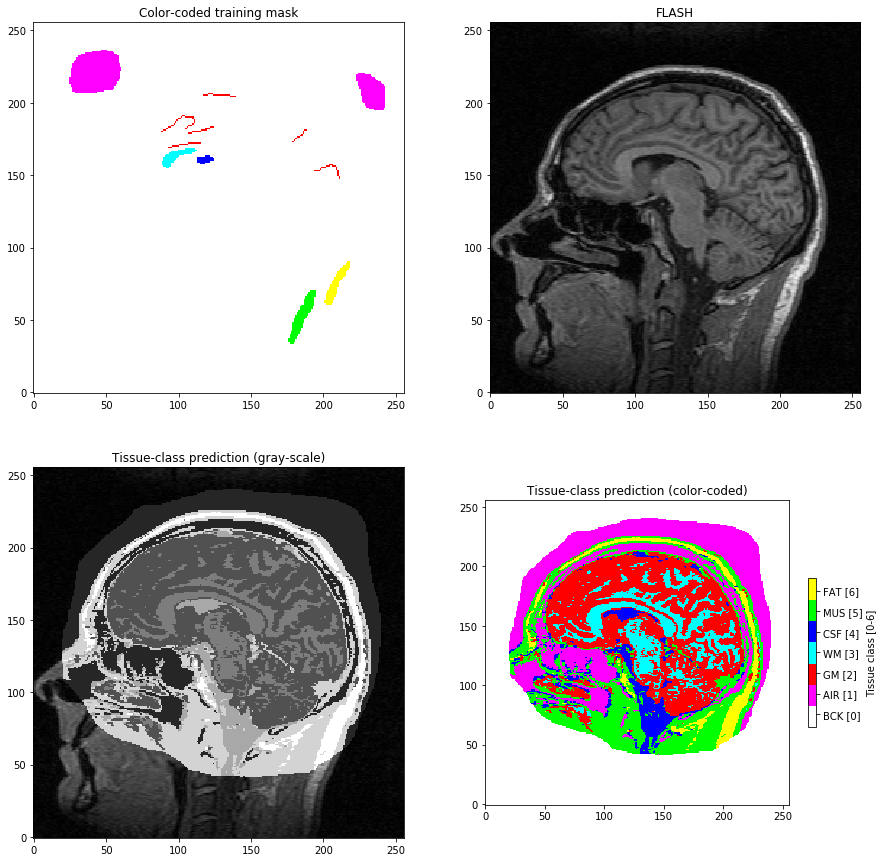

In [44]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
ax = axes.ravel()

ax[0].imshow(tmsk_data[:, :].T, cmap=cla_cmap, origin='lower')
ax[0].set_title('Color-coded training mask')
ax[0].axis('on')

ax[1].imshow(data[:, :, 0].squeeze().T, cmap='gray', origin='lower')
ax[1].set_title('FLASH')

# Hadamar (elemnt-wise) product np.multiply(a,b)
ax[2].imshow(cla_data[:, :].T / mx, cmap='gray', origin='lower')
ax[2].set_title('Tissue-class prediction (gray-scale)')

ax[3].imshow(np.multiply(cla_data[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[3].set_title('Tissue-class prediction (color-coded)')

cbar = fig.colorbar(cax, shrink=0.4, label='Tissue class [0-%d]' % clim[1]) 
tick_locs = np.linspace(clim[0]+0.5, clim[1]-0.5, ncla)
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(cla_names_num)

plt.show()

#fig.savefig('%s/prj/ELMED219/results/KNN_classification_results_on_flash.png' % (home),
#           transparent=False, dpi=300, bbox_inches="tight")

# Eksperimenter med en Random Forest klassifikator

  der klasse-lablene konverteres til en tall-verdi

In [45]:
df_y_train = pd.DataFrame(y_train,  columns=['Class'])
print(df_y_train.info())
df_y_train.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 1 columns):
Class    1986 non-null object
dtypes: object(1)
memory usage: 15.6+ KB
None


,0,1,2,3,4
Class,AIR,AIR,AIR,AIR,AIR


In [46]:
df_y_train['Class'] = df_y_train['Class'].map(cla_code)
y_train_num = df_y_train['Class'].values

**Random forest** klassifikator:

In [47]:
classifierRF = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [48]:
classifierRF.fit(X_train_scaled, y_train_num)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [49]:
y_rf_pred = classifierRF.predict(X_test_scaled)

Fyll data med de pixel-vise RF prediksjoner (skalert ned til intervallet [0, 1] )

In [50]:
mx = df_y_pred['Class'].values.max()  # Max class value
cla_data_rf = cla_data.copy()
cla_data_rf[dfTest['row'].values, dfTest['col'].values] = y_rf_pred / mx

# Visuell sammenlikning av KNN og RF prediksjon

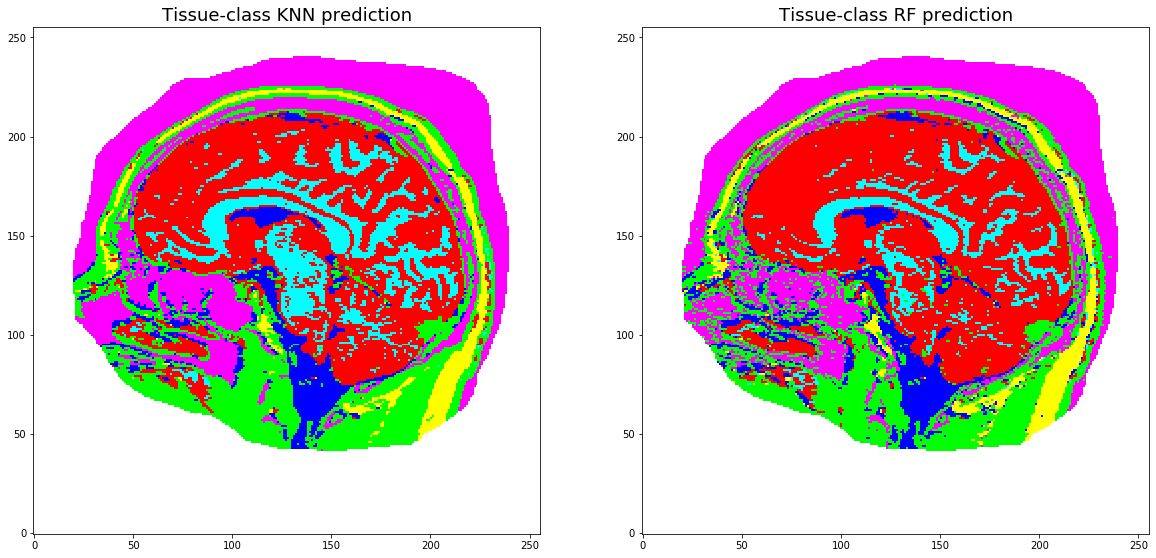

In [51]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
ax = axes.ravel()
ax[0].imshow(np.multiply(cla_data[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[0].set_title('Tissue-class KNN prediction', fontsize=18)
ax[1].imshow(np.multiply(cla_data_rf[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[1].set_title('Tissue-class RF prediction', fontsize=18)
plt.show()


## Evaluer resultatet - forvirringsmatrise mellom KNN og RF klassifikasjon
i.e. y_pred_knn ("true") versus y_pred_rf

In [52]:
from utils import plot_confusion_matrix, plot_confusion_matrix_with_colorbar

In [53]:
y_pred_knn = df_y_pred['Class'].values

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_knn, y_rf_pred)
print(cm)

[[ 8250     0     0    17   882     0]
 [   11 10283   125   161   189     7]
 [    0  1616  2372     0    67     3]
 [   68   115     0  2119   103     1]
 [  500   279    68   539  6045   281]
 [   13     5    31    48     4  1620]]


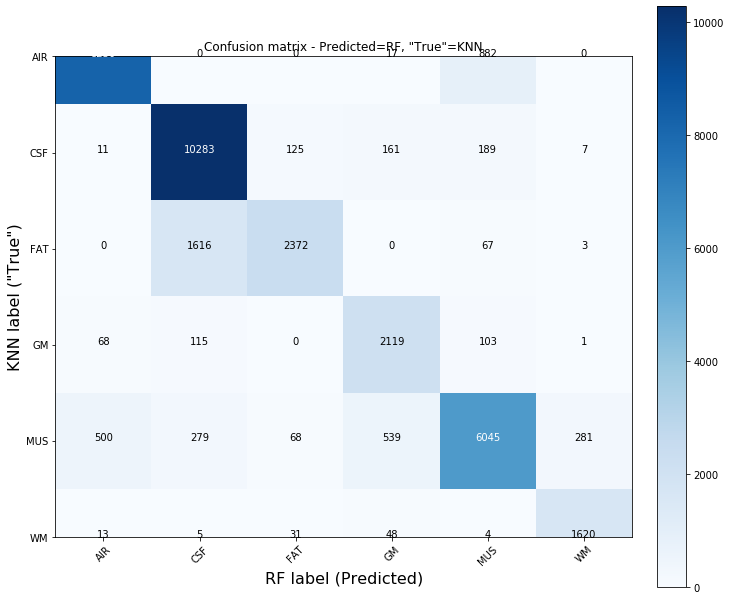

In [55]:
plot_confusion_matrix_with_colorbar(cm, classes=np.unique(y_pred), title='Confusion matrix - Predicted=RF, "True"=KNN', figsize=(10,10))
plt.ylabel('KNN label ("True")')
plt.xlabel('RF label (Predicted)')
plt.show()

Eller ved bruk av seaborn's `heatmap` (se [her](https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot) for problem med "first and last row cut in half of heatmap plot")

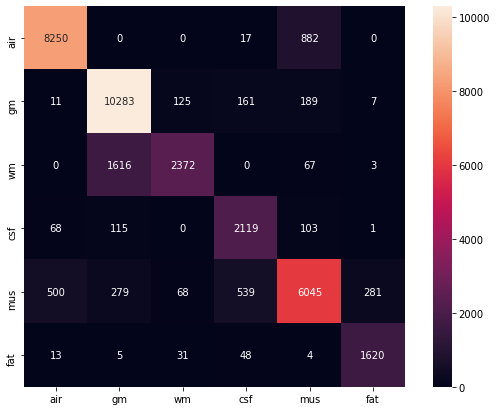

In [56]:
import seaborn as sn

df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])

plt.figure(figsize = (10,7))
ax=sn.heatmap(df_cm, annot=True, fmt='d', square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()